<a href="https://colab.research.google.com/github/JuanCappelletti/Consteel_H06/blob/main/torre_comportanmiento%20energetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#@title Ejecutar librerias { run: "auto", display-mode: "form" }
from matplotlib.font_manager import json_dump
from numpy.matrixlib.defmatrix import N
from operator import truediv
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objects as go
from IPython.display import Image

In [7]:

from prompt_toolkit.layout.dimension import D
#@title "Ejecutar Celda"
Url = "https://raw.githubusercontent.com/JuanCappelletti/Consteel_H06/main/TOMA%20TEMP.csv" #@param {type:"string"}
tab = True # @param {type:"boolean"}
datos = pd.read_csv(Url,sep=",",decimal=".")
df=pd.DataFrame(datos)
dfx=df.copy()
if tab==True:
   print(dfx)


           date       time  QENTRADA  REPOSICION  QRETORNO  TTORRE  TRETORNO
0     12/2/2023   05:00:00     11240         280     11510    34.9      39.6
1     12/2/2023   05:01:00     11480         270     11590    35.1      39.6
2     12/2/2023   05:02:00     11350         240     11620    35.0      39.7
3     12/2/2023   05:03:00     11370         280     11730    35.0      39.6
4     12/2/2023   05:04:00     11270         285     11670    34.9      39.5
...         ...        ...       ...         ...       ...     ...       ...
1436  13/2/2319   04:56:00     11290         263     11450    37.9      42.1
1437  13/2/2320   04:57:00     11220         259     11650    37.8      42.1
1438  13/2/2321   04:58:00     11240         268     11630    37.6      42.1
1439  13/2/2322   04:59:00     11300         304     11680    37.8      42.0
1440  13/2/2323   05:00:00     11310         289     11590    37.4      41.7

[1441 rows x 7 columns]


Cantidad de items sampleados:  1441
Fecha de la muestra:  12/2/2023 -  05:00:00 al 13/2/2323 -  05:00:00


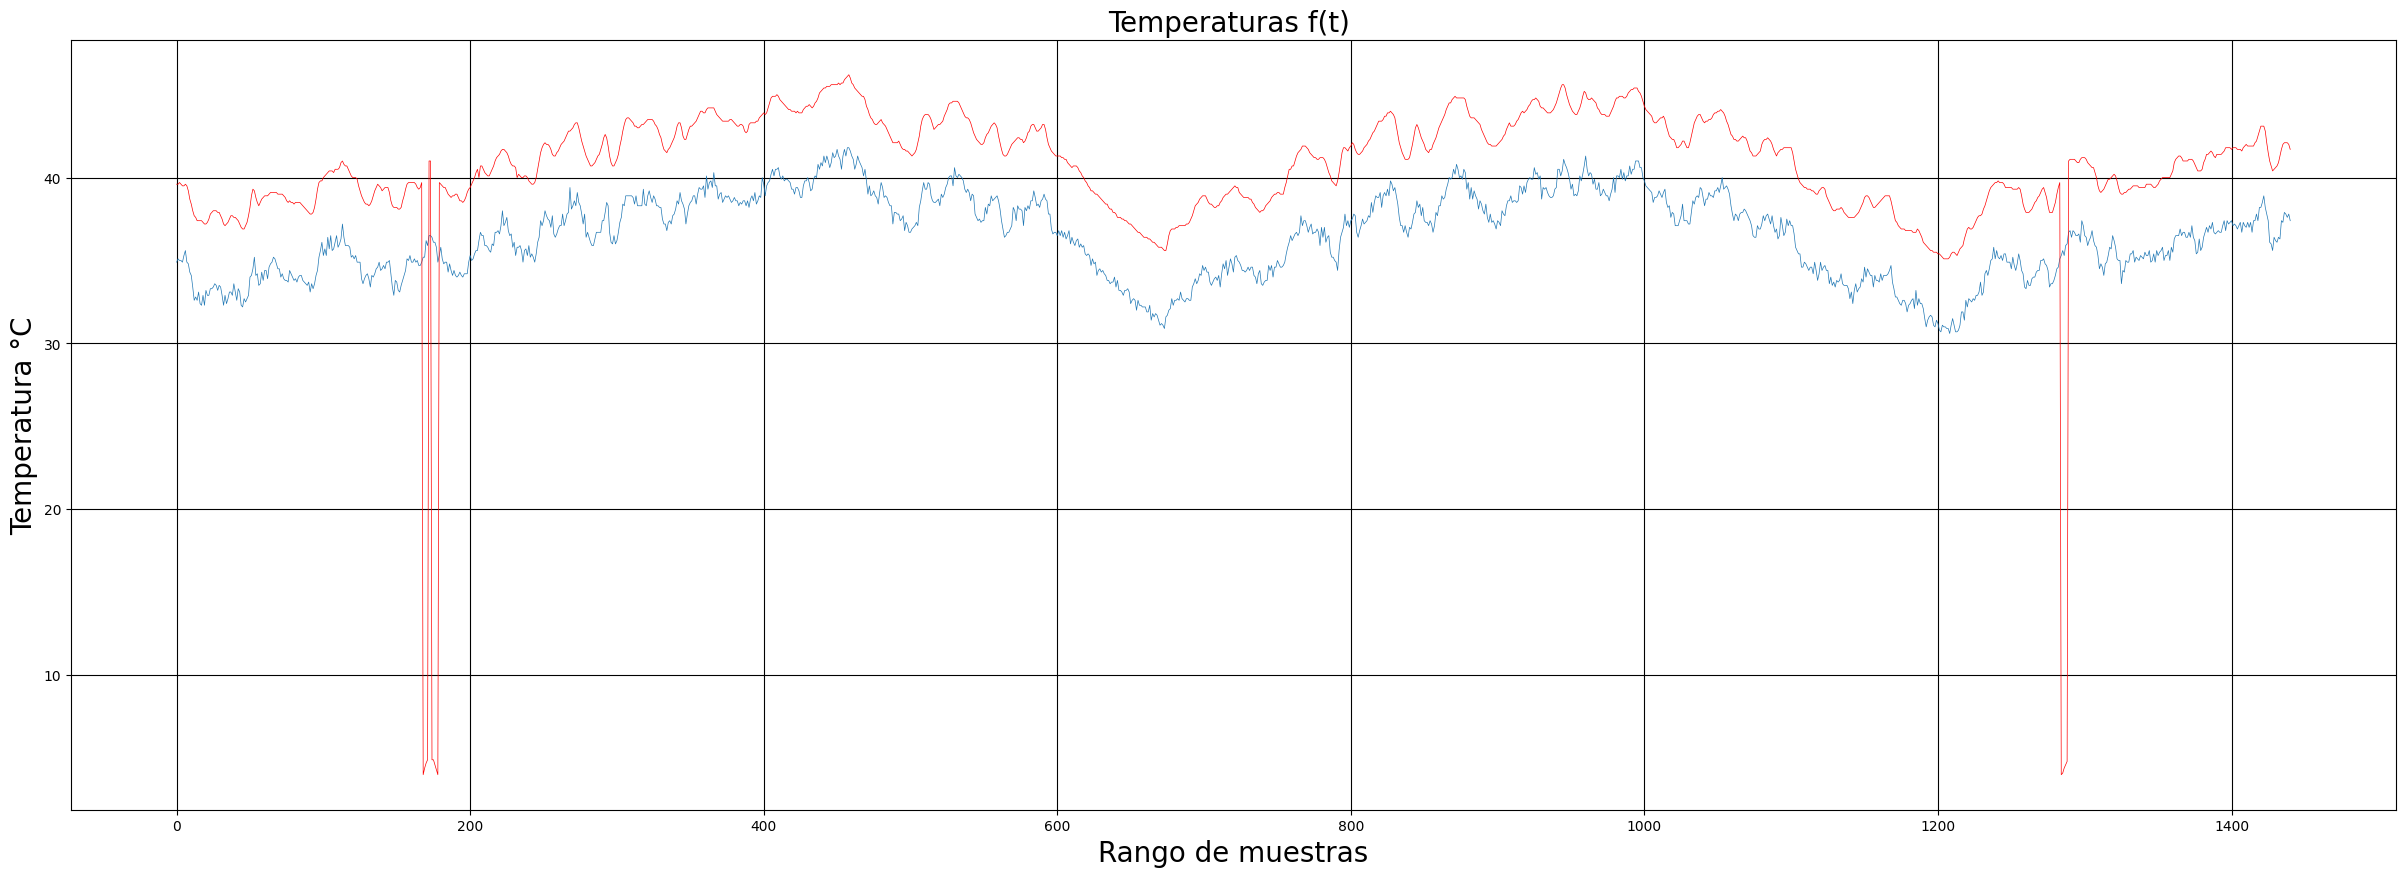

In [16]:
from matplotlib.ticker import AutoLocator
from io import DEFAULT_BUFFER_SIZE
from matplotlib.ticker import MaxNLocator
#@title Seleccionar parametros y ejecuar celda


InstrumentoParametro = 'PIR171' #@param {type:"raw"}
x = 'FQI171' #@param {type:"raw"}
y = 'PIR171' #@param {type:"raw"}
text='Caudal Nm3/h'
text1='Presión kg/cm2'
text2='Rango de muestras'
text3='Temperatura °C'
print('Cantidad de items sampleados: ', len(dfx.index))
print('Fecha de la muestra: ',dfx.date[0],'-',dfx.time[0], 'al',dfx.date[(len(dfx.index)-1)],'-',dfx.time[(len(dfx.index)-1)])
#print('Muestreo cada 1 minuto 30 seg ')

fig, (ax1)= plt.subplots(1, figsize=(30,10))
ax1.plot(dfx.index,dfx['TTORRE'],linewidth=0.5)
ax1.plot(dfx.index,dfx['TRETORNO'],linewidth=0.5,color='red')
ax1.set_title('Temperaturas f(t) ',fontsize=20)
ax1.set_xlabel(text2,fontsize=20)
ax1.set_ylabel(text3,fontsize=20)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
#ax1.xaxis.set_major_locator(MultipleLocator(100))
#ax1.xaxis.set_minor_locator(MultipleLocator(20))
#ax1.axhline(y=dfx['PIR171'].mean(),linewidth=2,color='black')
#ax1.axhline(y=np.amax(dfx['PIR171']), linewidth=2, color='green')
#ax1.axhline(y=np.amin(dfx['PIR171']), linewidth=2, color='blue')
#ax1.axhline(y=14,linewidth=2,color='black')
#ax1.axhline(y=13,linewidth=2,color='red')
labels2 = ax1.get_xticklabels()
labels3= ax1.get_yticklabels()
#plt.setp(labels2, rotation=60,fontsize=8, horizontalalignment='right')
plt.setp(labels3,fontsize=10, horizontalalignment='right')
ax1.axes.grid(True, which='minor',color='grey',axis='both')
ax1.axes.grid(True, which='major',color='black',axis='both')